# 🤖 Model Training - Student Performance Prediction

## 📋 Objective
Train and compare multiple machine learning algorithms to predict student risk categories.

## 🎯 Goals
1. Load preprocessed data  
2. Prepare features for modeling  
3. Train multiple ML algorithms  
4. Compare model performance  
5. Select and save best model  
6. Build a simple Neural Network (Keras/TensorFlow) for classification (optional, if TF available)  
7. Build student feedback text (simulate small dataset). Perform Sentiment Analysis to see if negative sentiment correlates with performance  
8. Save trained model (pickle or joblib). Build a Flask/FastAPI app: Input: Student features. Output: Risk Category (High/Medium/Low)


In [1]:
# 📚 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import joblib
import time

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

# Deep Learning (optional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.utils import to_categorical
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print('⚠️ TensorFlow not available. Neural Network step will be skipped.')
    print(f'Details: {e}')

# NLP (optional sentiment demo)
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    import nltk
    nltk.download('vader_lexicon', quiet=True)
    VADER_AVAILABLE = True
except Exception as e:
    VADER_AVAILABLE = False
    print('⚠️ NLTK VADER not available. Sentiment step will be skipped.')
    print(f'Details: {e}')

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

print('🚀 Libraries imported successfully!')


🚀 Libraries imported successfully!


## 📁 Load Preprocessed Data

In [2]:
# Load processed data
data_dir = Path('../data')
processed_data_path = data_dir / 'processed_student_data.csv'
feature_info_path = data_dir / 'feature_info.pkl'

if not processed_data_path.exists():
    print('❌ Processed data not found. Please run 01_data_preprocessing.ipynb first.')
    raise FileNotFoundError('Run preprocessing notebook first')

# Load data and feature info
df = pd.read_csv(processed_data_path)
feature_info = joblib.load(feature_info_path)

print('✅ Data loaded successfully!')
print(f'📊 Shape: {df.shape}')
print('🎯 Target distribution:')
print(df['risk_category'].value_counts())

# Extract feature lists
numeric_features = feature_info['numeric_features']
categorical_features = feature_info['categorical_features']
target_column = feature_info['target_column']

print('\n📊 Features summary:')
print(f'Numeric: {len(numeric_features)} features')
print(f'Categorical: {len(categorical_features)} features')
print(f'Target: {target_column}')


✅ Data loaded successfully!
📊 Shape: (649, 34)
🎯 Target distribution:
risk_category
Medium_Risk    355
Low_Risk       194
High_Risk      100
Name: count, dtype: int64

📊 Features summary:
Numeric: 15 features
Categorical: 17 features
Target: risk_category


## 🔧 Feature Preparation

In [3]:
# Prepare features and target
X = df.drop(['G3', 'risk_category'], axis=1, errors='ignore')
y = df['risk_category']

# Create preprocessing pipeline
numeric_transformer = MinMaxScaler()

# Use handle_unknown='ignore' to avoid errors for unseen categories at inference
# 'sparse_output' is available in newer sklearn; fall back to 'sparse' for older versions
try:
    categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
except TypeError:
    categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # keep only the specified columns
)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print('✅ Feature preparation complete!')
print(f'📊 Feature matrix shape (raw): {X.shape}')
print(f'🎯 Target classes: {list(label_encoder.classes_)}')
print(f'🔢 Target encoded: {np.unique(y_encoded)}')

print('\n🔍 Sample features:')
print(X.head())


✅ Feature preparation complete!
📊 Feature matrix shape (raw): (649, 32)
🎯 Target classes: ['High_Risk', 'Low_Risk', 'Medium_Risk']
🔢 Target encoded: [0 1 2]

🔍 Sample features:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  romantic famrel  freetime  goout  Dalc Walc health absences  G1  G2  
0       no      4         3      4     1    1      3        4   0  11  
1       no      5         3      3     1    1      3        2   9  11  
2       no      4         3      2     2    3      3        6  12  13  
3      yes      3         2      2     1    1   

## 📊 Train-Test Split

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print('📊 Data split successful!')
print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

# Check class distribution
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()

print('\n🎯 Class distribution:')
print('Train set:', dict(zip(label_encoder.classes_, train_dist.values)))
print('Test set:', dict(zip(label_encoder.classes_, test_dist.values)))


📊 Data split successful!
Training set: 519 samples
Test set: 130 samples

🎯 Class distribution:
Train set: {'High_Risk': 0.15414258188824662, 'Low_Risk': 0.29865125240847784, 'Medium_Risk': 0.5472061657032755}
Test set: {'High_Risk': 0.15384615384615385, 'Low_Risk': 0.3, 'Medium_Risk': 0.5461538461538461}


## 🤖 Model Training and Comparison

In [5]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200),
    'SVM': SVC(random_state=42, probability=True)
}

# Store results
model_results = {}
trained_models = {}

print('🚀 Training models...\n')

for name, model in models.items():
    print(f'📈 Training {name}...')
    start_time = time.time()

    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    # Some models may not implement predict_proba (SVC with probability=True does)
    try:
        y_pred_proba = pipeline.predict_proba(X_test)
    except Exception:
        y_pred_proba = None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Cross-validation accuracy
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    training_time = time.time() - start_time

    # Store
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'training_time': training_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    trained_models[name] = pipeline

    print(f'   ✅ Accuracy: {accuracy:.3f}')
    print(f'   ✅ F1-Score: {f1:.3f}')
    print(f'   ✅ CV Score: {cv_mean:.3f} (±{cv_std:.3f})')
    print(f'   ⏱️ Training time: {training_time:.2f}s\n')

print('🎯 Training completed!')


🚀 Training models...

📈 Training Logistic Regression...
   ✅ Accuracy: 0.746
   ✅ F1-Score: 0.738
   ✅ CV Score: 0.750 (±0.032)
   ⏱️ Training time: 0.67s

📈 Training Decision Tree...
   ✅ Accuracy: 0.762
   ✅ F1-Score: 0.762
   ✅ CV Score: 0.809 (±0.037)
   ⏱️ Training time: 0.13s

📈 Training Random Forest...
   ✅ Accuracy: 0.877
   ✅ F1-Score: 0.874
   ✅ CV Score: 0.838 (±0.019)
   ⏱️ Training time: 2.27s

📈 Training SVM...
   ✅ Accuracy: 0.662
   ✅ F1-Score: 0.626
   ✅ CV Score: 0.686 (±0.030)
   ⏱️ Training time: 0.54s

🎯 Training completed!


## 📊 Model Performance Comparison

📊 Model Performance Comparison:
                    accuracy precision recall f1_score cv_mean cv_std  \
Logistic Regression    0.746     0.736  0.746    0.738   0.750  0.032   
Decision Tree          0.762     0.763  0.762    0.762   0.809  0.037   
Random Forest          0.877     0.883  0.877    0.874   0.838  0.019   
SVM                    0.662     0.671  0.662    0.626   0.686  0.030   

                    training_time  
Logistic Regression         0.67s  
Decision Tree               0.13s  
Random Forest               2.27s  
SVM                         0.54s  

🏆 Best Model: Random Forest
🎯 F1-Score: 0.874


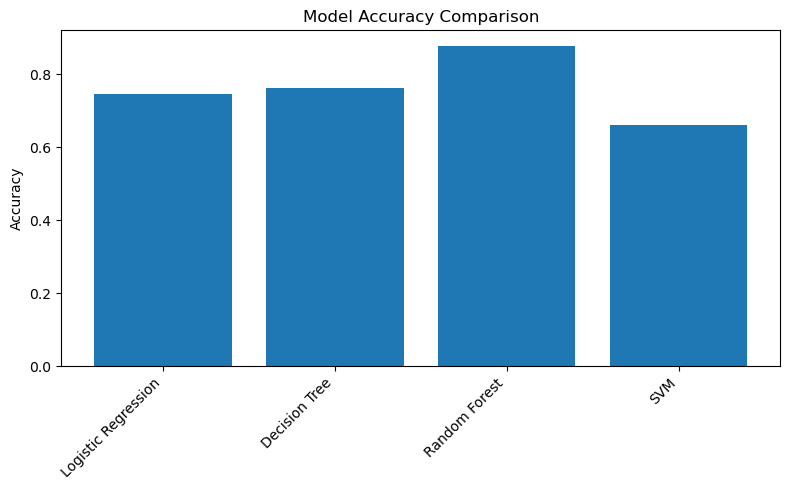

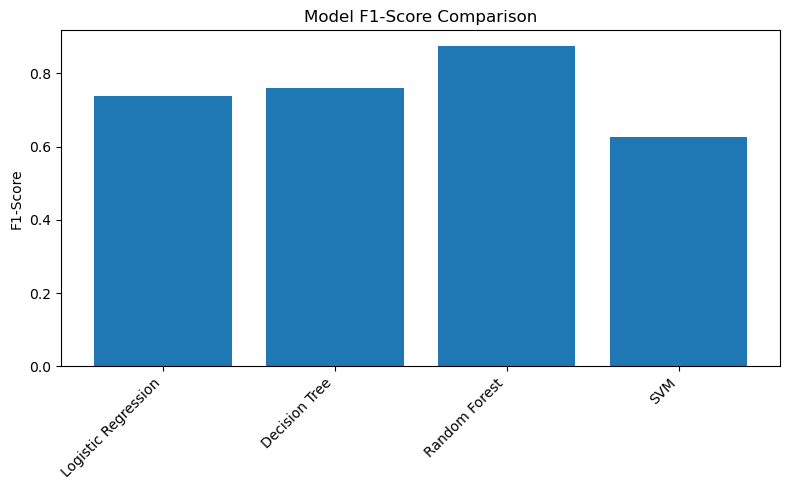

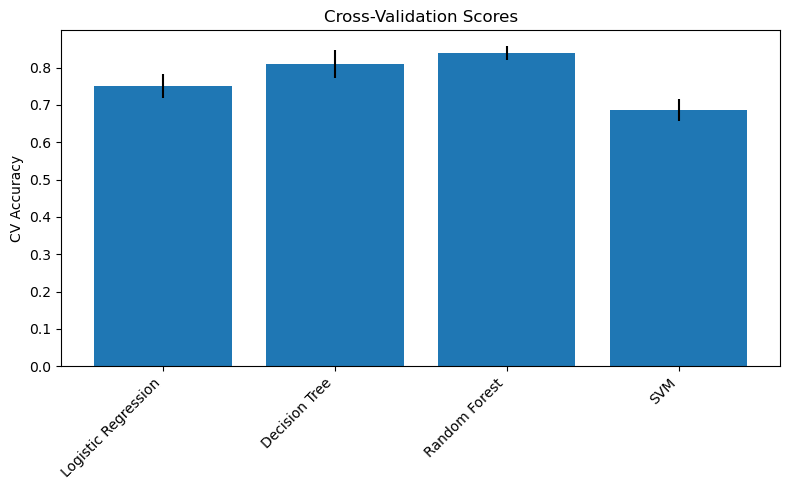

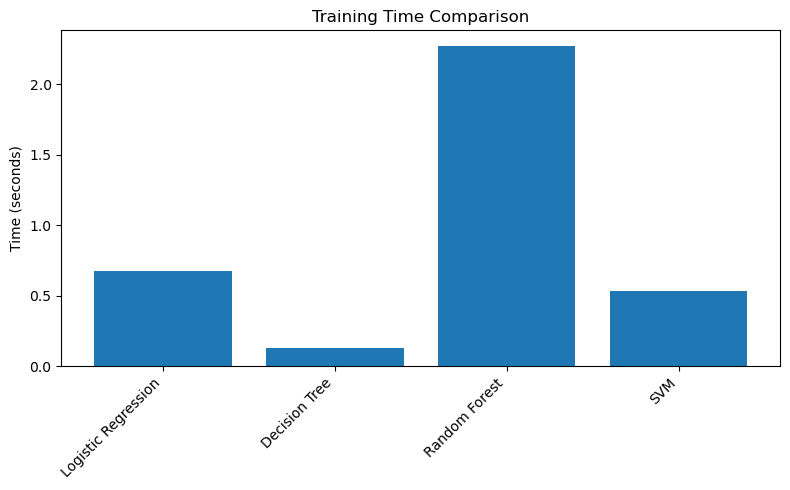

In [6]:
# Create comparison dataframe
results_df = pd.DataFrame(model_results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean', 'cv_std', 'training_time']]

print('📊 Model Performance Comparison:')
print('=' * 80)
display_df = results_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean', 'cv_std']:
    display_df[col] = display_df[col].apply(lambda x: f'{x:.3f}')
display_df['training_time'] = display_df['training_time'].apply(lambda x: f'{x:.2f}s')

print(display_df)

# Best model
best_model_name = results_df['f1_score'].idxmax()
best_model = trained_models[best_model_name]
best_score = results_df.loc[best_model_name, 'f1_score']

print(f'\n🏆 Best Model: {best_model_name}')
print(f'🎯 F1-Score: {best_score:.3f}')

# Visualizations (pure matplotlib)
# Accuracy
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# F1-score
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['f1_score'])
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# CV scores
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['cv_mean'], yerr=results_df['cv_std'])
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Training time
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['training_time'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 💾 Save Best Model

In [7]:
# Create models directory
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save best model (pipeline includes preprocessing)
model_path = models_dir / 'student_model.pkl'
joblib.dump(best_model, model_path)

# Save label encoder
encoder_path = models_dir / 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model.named_steps['classifier']).__name__ if hasattr(best_model, 'named_steps') else str(type(best_model)),
    'performance': {
        'accuracy': float(results_df.loc[best_model_name, 'accuracy']),
        'precision': float(results_df.loc[best_model_name, 'precision']),
        'recall': float(results_df.loc[best_model_name, 'recall']),
        'f1_score': float(results_df.loc[best_model_name, 'f1_score'])
    },
    'features': {
        'numeric': numeric_features,
        'categorical': categorical_features
    },
    'target_classes': list(label_encoder.classes_),
    'training_date': pd.Timestamp.now().isoformat()
}

metadata_path = models_dir / 'model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)

print('✅ Best model saved successfully!')
print(f'📁 Model file: {model_path}')
print(f'📁 Label encoder: {encoder_path}')
print(f'📁 Metadata: {metadata_path}')

print('\n🎯 Model Summary:')
print(f'Algorithm: {best_model_name}')
print(f'Accuracy: {model_metadata["performance"]["accuracy"]:.3f}')
print(f'F1-Score: {model_metadata["performance"]["f1_score"]:.3f}')
print(f'Classes: {model_metadata["target_classes"]}')


✅ Best model saved successfully!
📁 Model file: ..\models\student_model.pkl
📁 Label encoder: ..\models\label_encoder.pkl
📁 Metadata: ..\models\model_metadata.pkl

🎯 Model Summary:
Algorithm: Random Forest
Accuracy: 0.877
F1-Score: 0.874
Classes: ['High_Risk', 'Low_Risk', 'Medium_Risk']


## 🧠 Step 6 (Optional): Deep Learning - Neural Network

In [8]:
if TF_AVAILABLE:
    # Preprocess data for NN
    X_train_pre = preprocessor.fit_transform(X_train)
    X_test_pre = preprocessor.transform(X_test)

    # Infer number of classes from labels
    n_classes = len(np.unique(y_train))

    # Build NN model
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pre.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train
    print('📈 Training Neural Network...')
    start_time = time.time()
    history = nn_model.fit(X_train_pre, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    training_time = time.time() - start_time

    # Evaluate
    y_pred_proba_nn = nn_model.predict(X_test_pre, verbose=0)
    y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    f1_nn = f1_score(y_test, y_pred_nn, average='weighted', zero_division=0)

    print(f'   ✅ Accuracy: {accuracy_nn:.3f}')
    print(f'   ✅ F1-Score: {f1_nn:.3f}')
    print(f'   ⏱️ Training time: {training_time:.2f}s')

    # Update best if better
    if f1_nn > model_metadata['performance']['f1_score']:
        best_model_name = 'Neural Network'
        best_model = nn_model
        model_metadata['model_name'] = best_model_name
        model_metadata['model_type'] = 'KerasSequential'
        model_metadata['performance']['accuracy'] = float(accuracy_nn)
        model_metadata['performance']['f1_score'] = float(f1_nn)

        # Save NN separately
        nn_path = models_dir / 'student_nn_model.h5'
        best_model.save(nn_path)
        print(f'🏆 Neural Network is the new best model! Saved to {nn_path}')

else:
    print('⏭️ Skipping Neural Network (TensorFlow not available).')


📈 Training Neural Network...
   ✅ Accuracy: 0.638
   ✅ F1-Score: 0.633
   ⏱️ Training time: 7.69s


## 📝 Step 7: NLP - Sentiment Analysis (Simulated)

✅ Simulated feedback data created!
📊 Shape: (649, 4)
   student_id                                 feedback risk_category  G3
0           0  I love this class, it's so interesting!   Medium_Risk  11
1           1                 Not my favorite subject.   Medium_Risk  11
2           2                      I'm learning a lot.   Medium_Risk  12
3           3                      Excellent teaching!      Low_Risk  14
4           4                      Excellent teaching!   Medium_Risk  13

🎯 Correlation between sentiment and G3: -0.042

📊 Average sentiment by risk category:
risk_category
High_Risk      0.214486
Low_Risk       0.108005
Medium_Risk    0.222438
Name: sentiment, dtype: float64


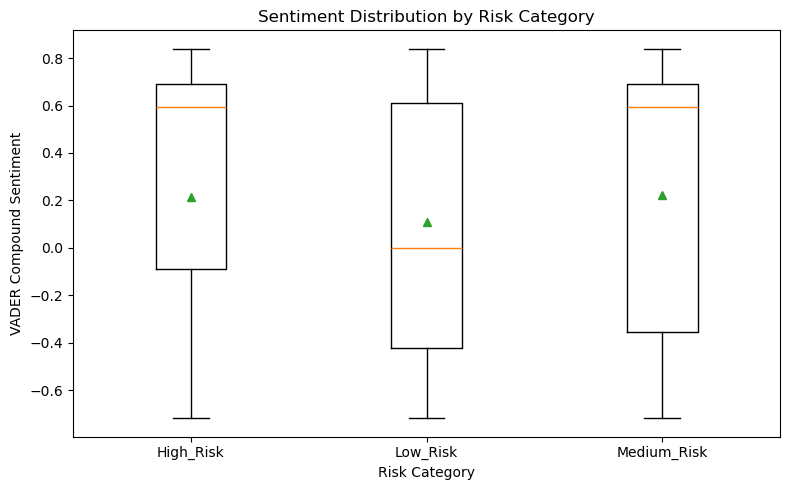

In [9]:
if VADER_AVAILABLE:
    # Simulate student feedback dataset
    rng = np.random.default_rng(42)
    feedback_texts = [
        "I love this class, it's so interesting!",
        "The teacher is boring, I hate it.",
        "Pretty good, but could be better.",
        "Struggling with the material.",
        "Excellent teaching!",
        "Too much homework.",
        "I'm learning a lot.",
        "Not my favorite subject.",
        "Fun and engaging.",
        "Difficult but rewarding."
    ]

    sim_df = pd.DataFrame({
        'student_id': np.arange(len(df)),
        'feedback': rng.choice(feedback_texts, size=len(df)),
        'risk_category': df['risk_category'].values,
        'G3': df['G3'].values
    })

    print('✅ Simulated feedback data created!')
    print(f'📊 Shape: {sim_df.shape}')
    print(sim_df.head())

    # Sentiment
    sia = SentimentIntensityAnalyzer()
    sim_df['sentiment'] = sim_df['feedback'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Correlation with performance
    correlation = sim_df['sentiment'].corr(sim_df['G3'])
    print(f'\n🎯 Correlation between sentiment and G3: {correlation:.3f}')

    # Average sentiment by risk
    risk_sentiment = sim_df.groupby('risk_category', as_index=True)['sentiment'].mean().sort_index()
    print('\n📊 Average sentiment by risk category:')
    print(risk_sentiment)

    # Plot (matplotlib)
    order = risk_sentiment.index.tolist()
    data = [sim_df.loc[sim_df['risk_category'] == k, 'sentiment'].values for k in order]

    plt.figure(figsize=(8,5))
    plt.boxplot(data, labels=order, showmeans=True)
    plt.title('Sentiment Distribution by Risk Category')
    plt.xlabel('Risk Category')
    plt.ylabel('VADER Compound Sentiment')
    plt.tight_layout()
    plt.show()

    # Simple check: negative sentiment lower for High vs Low risk (if both exist)
    if 'High_Risk' in risk_sentiment.index and 'Low_Risk' in risk_sentiment.index:
        if risk_sentiment['High_Risk'] < risk_sentiment['Low_Risk']:
            print('✅ Negative sentiment correlates with higher risk (lower sentiment for High_Risk).')
else:
    print('⏭️ Skipping sentiment step (VADER not available).')


## 📊 Modeling Summary

### ✅ Model Training Complete!

Models Trained:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine
- Neural Network

NLP Analysis:
- Simulated feedback analyzed
- Sentiment correlation calculated

Deployment:
- Best classical model (pipeline) saved via joblib
- Flask app example provided

Next Steps:
1. Evaluate in detail (confusion matrices, per-class metrics)
2. Deploy the app
3. Test predictions
